# Chapter10 - LSTM Forecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

In [36]:
df = pd.read_csv("dataset_demand_forecasting_sd.csv")
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


### Timeseries Based

In [37]:
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


In [38]:
len(df)

2547

In [39]:
df['Sales'] = df["Sales"].rolling(window=20).mean()
df = df.dropna()

In [41]:
ds = df[["Sales"]].values

In [42]:
ds

array([[ 11956.6 ],
       [ 12030.3 ],
       [ 11959.45],
       ...,
       [ 98101.  ],
       [ 99879.4 ],
       [100624.25]])

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

In [44]:
split = 0.75
train_size = int(len(ds) * split)
test_size = len(ds) - train_size

In [45]:
train = ds[0:train_size,:]
test = ds[train_size:len(ds),:]

In [46]:
print(train.shape)

(1896, 1)


In [47]:
print(test.shape)

(632, 1)


In [48]:
def dataset_generator(df, lookback=0):
    df_x = []
    df_y = []
    
    for i in range(len(df) - lookback - 1):
        tmp = df[i:(i+lookback), 0]
        df_x.append(tmp)
        df_y.append(df[i + lookback, 0])
        
    return np.array(df_x), np.array(df_y)

In [4]:
lookback = 100

In [49]:
X_train, y_train = dataset_generator(train, lookback)
X_test, y_test = dataset_generator(test, lookback)

In [50]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [6]:
model = Sequential()
model.add(LSTM(2, input_shape=(1, lookback)))
model.add(Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2)                 824       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 827
Trainable params: 827
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1795/1795 - 3s - loss: 0.0044
Epoch 2/10
1795/1795 - 2s - loss: 9.0355e-04
Epoch 3/10
1795/1795 - 2s - loss: 6.7831e-04
Epoch 4/10
1795/1795 - 2s - loss: 6.2318e-04
Epoch 5/10
1795/1795 - 2s - loss: 5.0483e-04
Epoch 6/10
1795/1795 - 2s - loss: 4.9135e-04
Epoch 7/10
1795/1795 - 2s - loss: 4.5095e-04
Epoch 8/10
1795/1795 - 2s - loss: 4.1043e-04
Epoch 9/10
1795/1795 - 2s - loss: 3.7089e-04
Epoch 10/10
1795/1795 - 2s - loss: 4.0027e-04


In [52]:
history.history.keys()

dict_keys(['loss'])

In [53]:
history.history["loss"]

[0.004442066885530949,
 0.0009035529801622033,
 0.0006783092394471169,
 0.0006231785519048572,
 0.0005048273014836013,
 0.0004913458251394331,
 0.00045094609959051013,
 0.0004104262625332922,
 0.0003708932490553707,
 0.0004002676287200302]

Text(0, 0.5, 'Mean Squared Error')

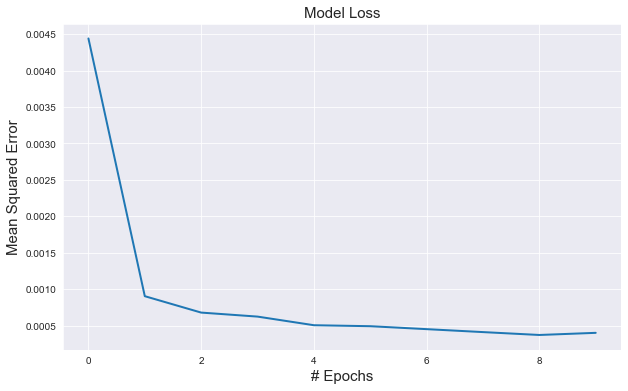

In [54]:
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], linewidth=2)
plt.title("Model Loss", fontsize=15)
plt.xlabel("# Epochs", fontsize=15)
plt.ylabel("Mean Squared Error", fontsize=15)

In [55]:
X_train_forecast = scaler.inverse_transform(model.predict(X_train))
y_train = scaler.inverse_transform([y_train.ravel()])

X_test_forecast = scaler.inverse_transform(model.predict(X_test))
y_test = scaler.inverse_transform([y_test.ravel()])

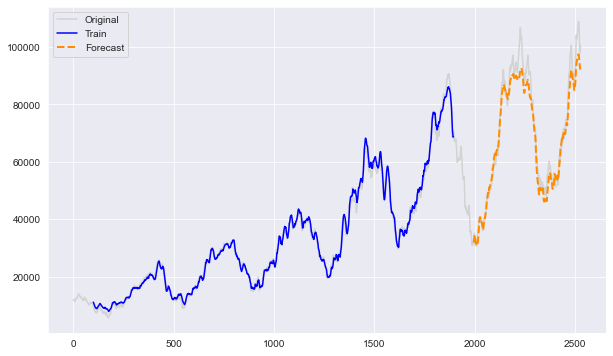

In [58]:
plt.figure(figsize=(10,6))

# Plot original dataset:
plt.plot(list(range(0, len(ds))), scaler.inverse_transform(ds), label="Original", color="lightgrey")

# Plot training data:
train_y_plot = X_train_forecast
train_x_plot = [i+lookback for i in list(range(0, len(X_train_forecast)))]
plt.plot(train_x_plot, train_y_plot , label="Train", color="blue")

# Plot forecasted data:
test_y_plot = X_test_forecast
test_x_plot = [i+lookback*2 for i in list(range(len(X_train_forecast), len(X_train_forecast)+len(X_test_forecast)))]
plt.plot(test_x_plot, test_y_plot , label="Forecast", color="darkorange", linewidth=2, linestyle="--")

plt.legend()